In [25]:
setwd('/import/liujing/data/my')
load('../combat_edata1.rda')
library(dplyr)
expr = combat_edata1 %>%  t() %>%  as.data.frame()  
bulk3.group = read.csv('bulk.3.group.csv',row.names = 1)
expr1 = expr[rownames(bulk3.group),] %>% t() %>%  as.data.frame()
dim(expr1)
prot = read.table('./prot.txt',header = T,sep = '\t')
expr1 = expr1 %>%  dplyr::filter(rownames(.) %in% prot$GeneName)
dim(expr1)
group.all1 = bulk3.group
dataExpr = expr1
library(WGCNA)
library(reshape2)
library(stringr)
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()
#exprMat <- "./fpkm.txt"
type = "unsigned"
corType = "pearson"
corFnc = ifelse(corType=="pearson", cor, bicor)
maxPOutliers = ifelse(corType=="pearson",1,0.05)
robustY = ifelse(corType=="pearson",T,F)

m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.15))[2],0.01)),]
dataExpr <- as.data.frame(t(dataExprVar))
gsg = goodSamplesGenes(dataExpr, verbose = 3)

[1] 28056    59

[1] 17525    59

Allowing parallel execution with up to 255 working processes.
 Flagging genes and samples with too many missing values...
  ..step 1


In [26]:
dim(dataExpr)

[1]    59 14896

In [27]:
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}


In [28]:
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
dim(dataExpr)

[1]    59 14896

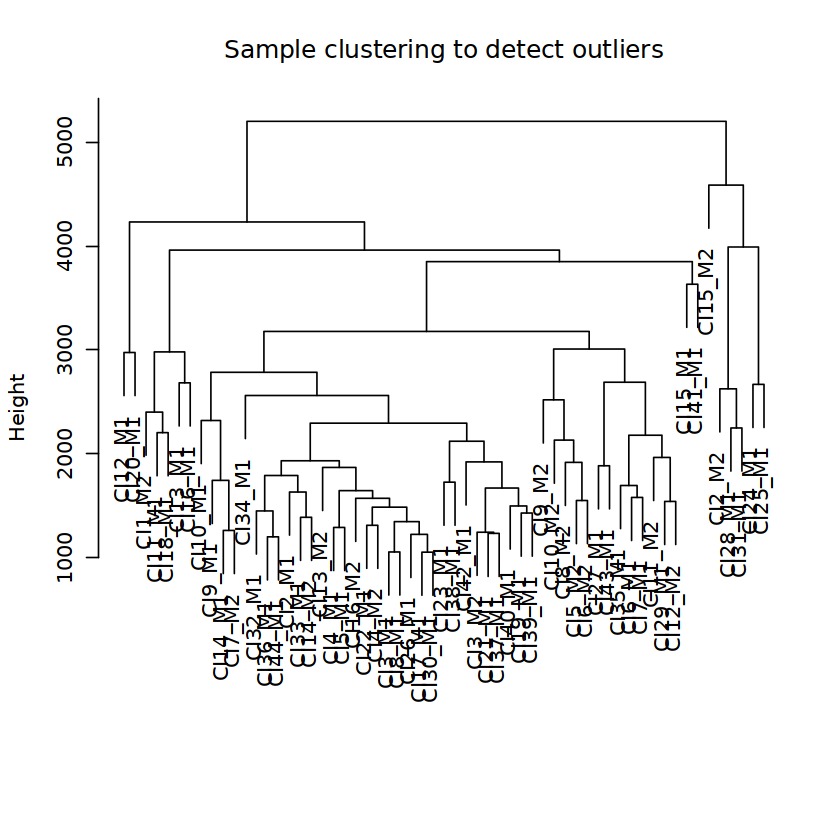

In [29]:
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

In [30]:
powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

pickSoftThreshold: will use block size 3003.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3003 of 14896
   ..working on genes 3004 through 6006 of 14896
   ..working on genes 6007 through 9009 of 14896
   ..working on genes 9010 through 12012 of 14896
   ..working on genes 12013 through 14896 of 14896
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.602  0.915          0.839 3940.00  4.13e+03 6090.0
2      2    0.238 -0.350          0.594 1660.00  1.67e+03 3660.0
3      3    0.559 -0.798          0.774  867.00  7.89e+02 2560.0
4      4    0.643 -1.030          0.839  515.00  4.12e+02 1930.0
5      5    0.680 -1.210          0.861  332.00  2.32e+02 1520.0
6      6    0.701 -1.340          0.873  227.00  1.37e+02 1230.0
7      7    0.724 -1.430          0.886  161.00  8.41e+01 1020.0
8      8    0.742 -1.500          0.896  118.00  5.33e+01  862.0
9      9    0.734 -1.580          0.889   89.20  3.46e+01  7

In [31]:
options(repr.plot.width = 9)

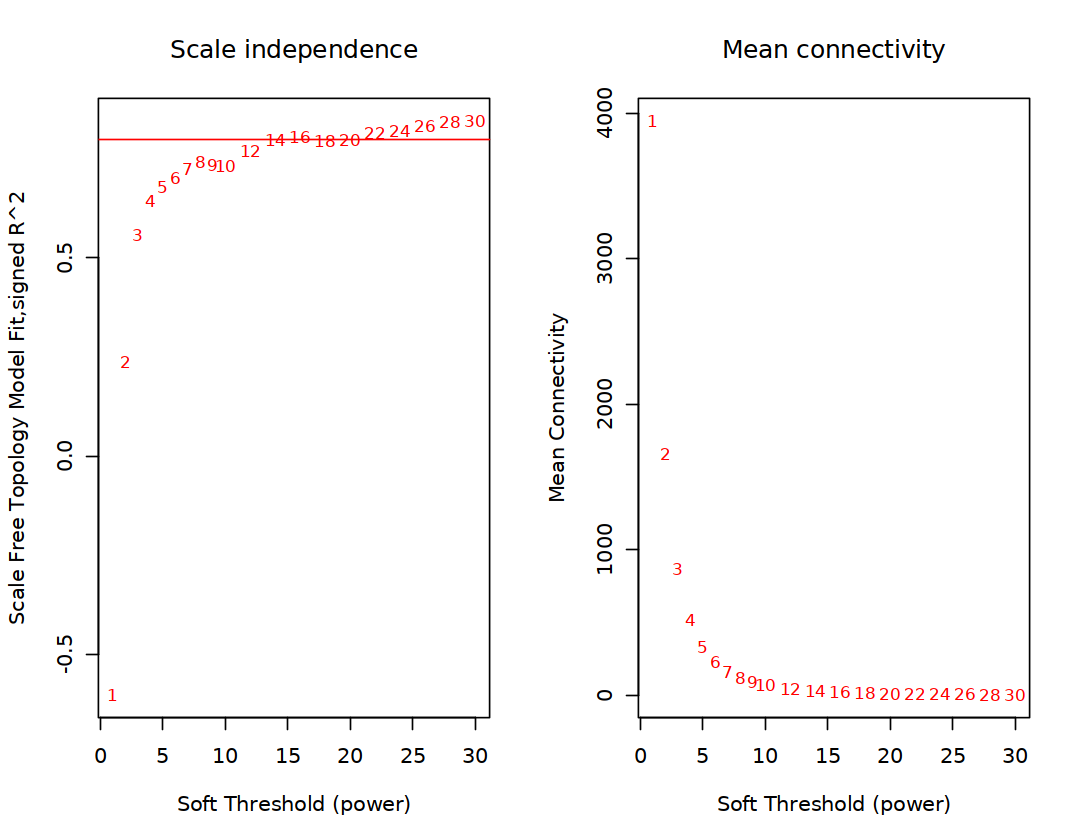

In [32]:
par(mfrow = c(1,2))
cex1 = 0.8
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.8,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [33]:
power = sft$powerEstimate
power

[1] NA

In [34]:
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}

In [35]:
exprMat='data.txt'

In [36]:
net = blockwiseModules(dataExpr, power = power, maxBlockSize = nGenes,
                       TOMType = type, minModuleSize = 50,
                       reassignThreshold = 0, mergeCutHeight = 0.5,  # 模块太多修改这个
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs=TRUE, corType = corType, 
                       maxPOutliers=maxPOutliers, loadTOMs=TRUE,
                       saveTOMFileBase = paste0(exprMat, ".tom"),
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 128 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file data.txt.tom-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 339 genes from module 1 because their KME is too low.
     ..removing 170 genes from module 2 because their KME is too low.
     ..removing 157 genes from module 3 because their KME is too low.
     ..removing 67 genes from module 4 because their KME is too low.
     ..removing 88 genes from module 5 because their KME is too low.
     ..removing 32 genes from module 6 because their KME is too low.
     ..removing 37 genes from module 

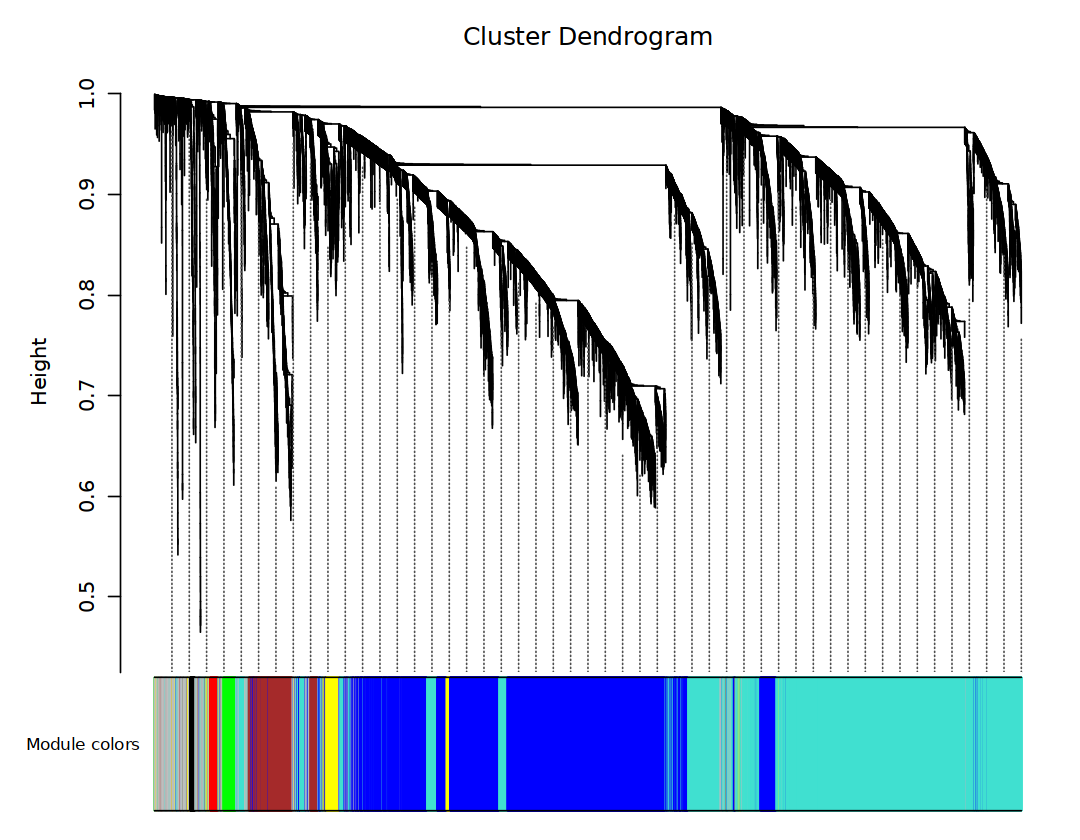

In [37]:
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [38]:
MEs = net$MEs
MEs_col = MEs
colnames(MEs_col) = paste0("ME", labels2colors(
  as.numeric(str_replace_all(colnames(MEs),"ME",""))))
MEs_col = orderMEs(MEs_col)

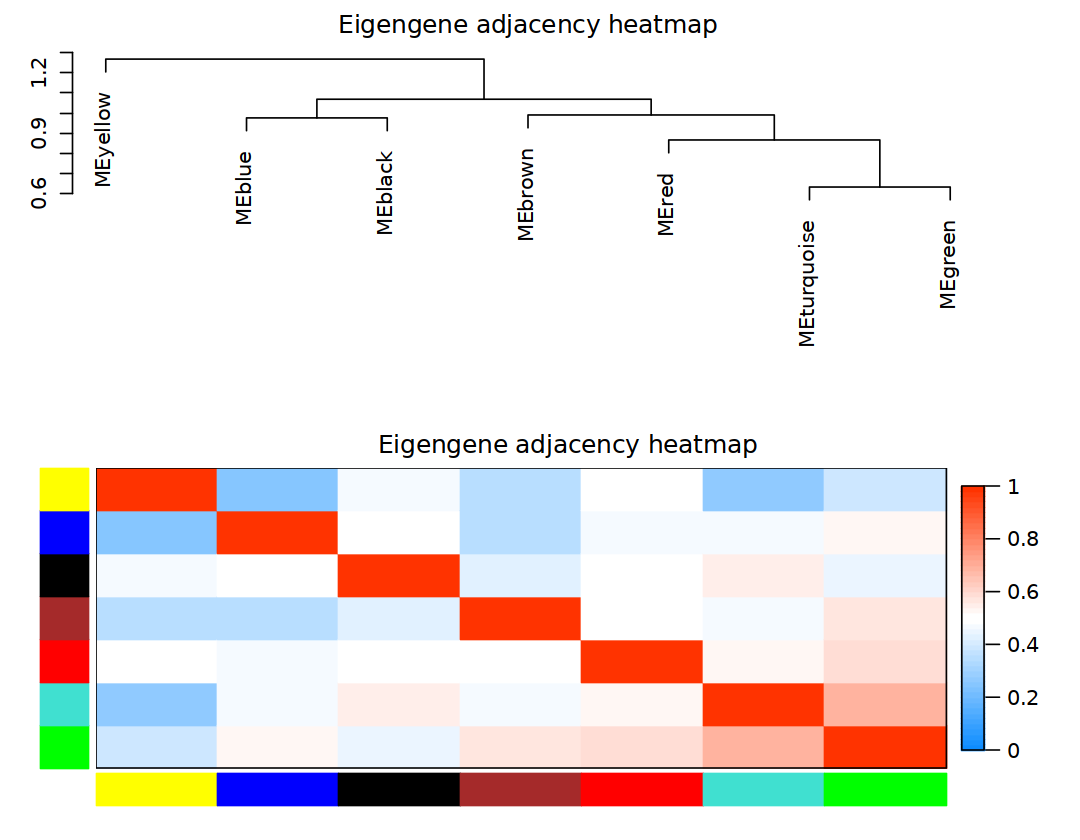

In [39]:
plotEigengeneNetworks(MEs_col, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)

In [40]:
TOM = TOMsimilarityFromExpr(dataExpr, power=power, corType=corType, networkType=type)

TOM calculation: adjacency..
..will use 128 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [41]:
group.all1  = group.all1 %>%  tibble::rownames_to_column(.,'sample')

In [42]:
group.all1$group = as.character(group.all1$group )

In [43]:
design <- model.matrix(~0 + group.all1$group)


In [44]:
dimnames(design) <- list(group.all1$sample, sort(unique(group.all1$group)))


In [45]:

design <- design[rownames(MEs_col),]
# 计算 pearson 相关性和显著性
modTraitCor <- cor(MEs_col, design, use = "p")
modTraitP <- corPvalueStudent(modTraitCor, dim(group.all1)[1])

In [46]:
modTraitCorP = bicorAndPvalue(MEs_col, design)
modTraitCor = modTraitCorP$bicor
modTraitP   = modTraitCorP$p

Warning message in bicor(x, y, use = use, ...):
"bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD."


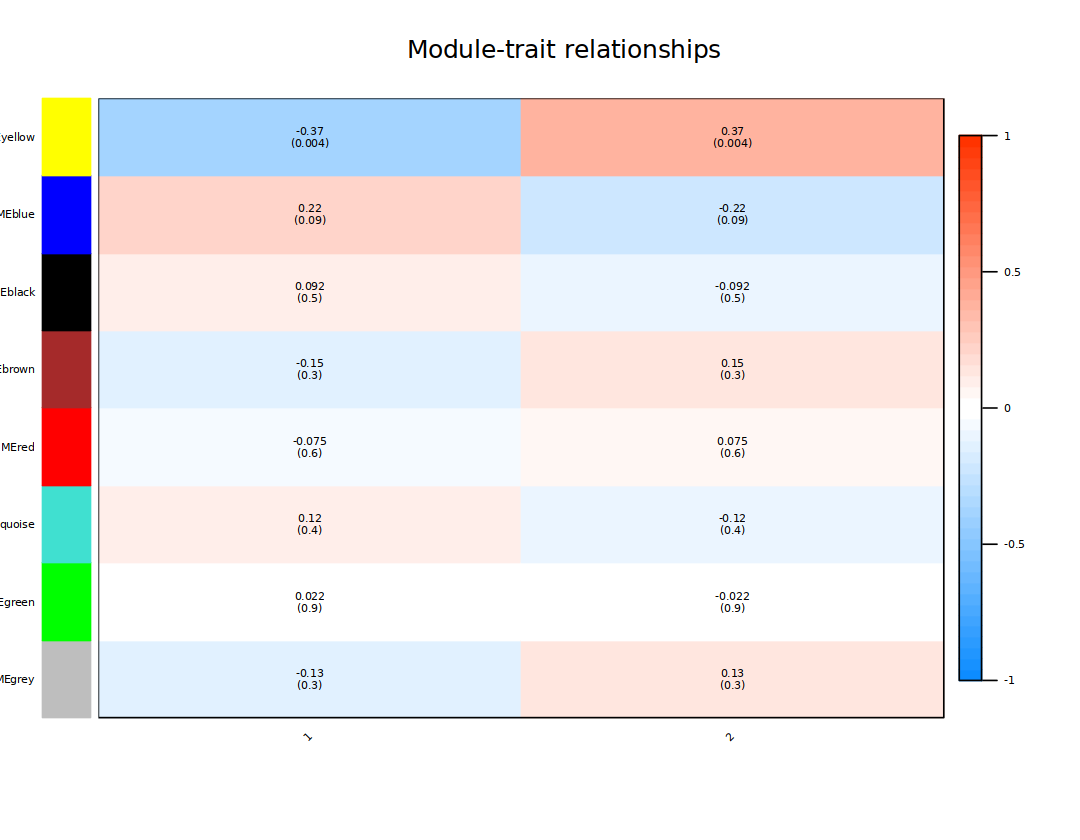

In [47]:
textMatrix <- paste0(signif(modTraitCor, 2), "\n(", signif(modTraitP, 1), ")")
dim(textMatrix) <- dim(modTraitCor)
labeledHeatmap(
  Matrix = modTraitCor,
  xLabels = colnames(design),
  yLabels = colnames(MEs_col),
  cex.lab = 0.5,
  ySymbols = colnames(MEs_col),
  colorLabels = FALSE,
  colors = blueWhiteRed(50),
  textMatrix = textMatrix,
  setStdMargins = FALSE,
  cex.text = 0.5,
  zlim = c(-1, 1),
  main = paste("Module-trait relationships")
)

In [48]:
dat = dataExpr

In [49]:
nSamples <- nrow(dat)
#计算MM值和GS值
modNames <- substring(colnames(MEs_col), 3) ##切割，从第三个字符开始保存
geneModuleMembership <- as.data.frame(cor(dat, MEs, use = "p")) #算出每个模块跟基因的Pearson相关系数矩阵
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples)) #计算MM值对应的P值
names(geneModuleMembership) <- paste("MM", modNames, sep="")
names(MMPvalue) <- paste("p.MM", modNames, sep="")
geneTraitSignificance <- as.data.frame(cor(dat, design, use = "p")) 

In [50]:
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))
names(geneTraitSignificance) <- paste("GS.", colnames(design), sep="")
names(GSPvalue) <- paste("p.GS.", colnames(design), sep="")

In [51]:
module <- "yellow"
column <- match(module, modNames)  ##在所有模块中匹配选择的模块，返回所在的位置
brown_moduleGenes <- names(net$colors)[which(moduleColors == module)]
MM <- abs(geneModuleMembership[brown_moduleGenes, column])
GS <- abs(geneTraitSignificance[brown_moduleGenes, 1])

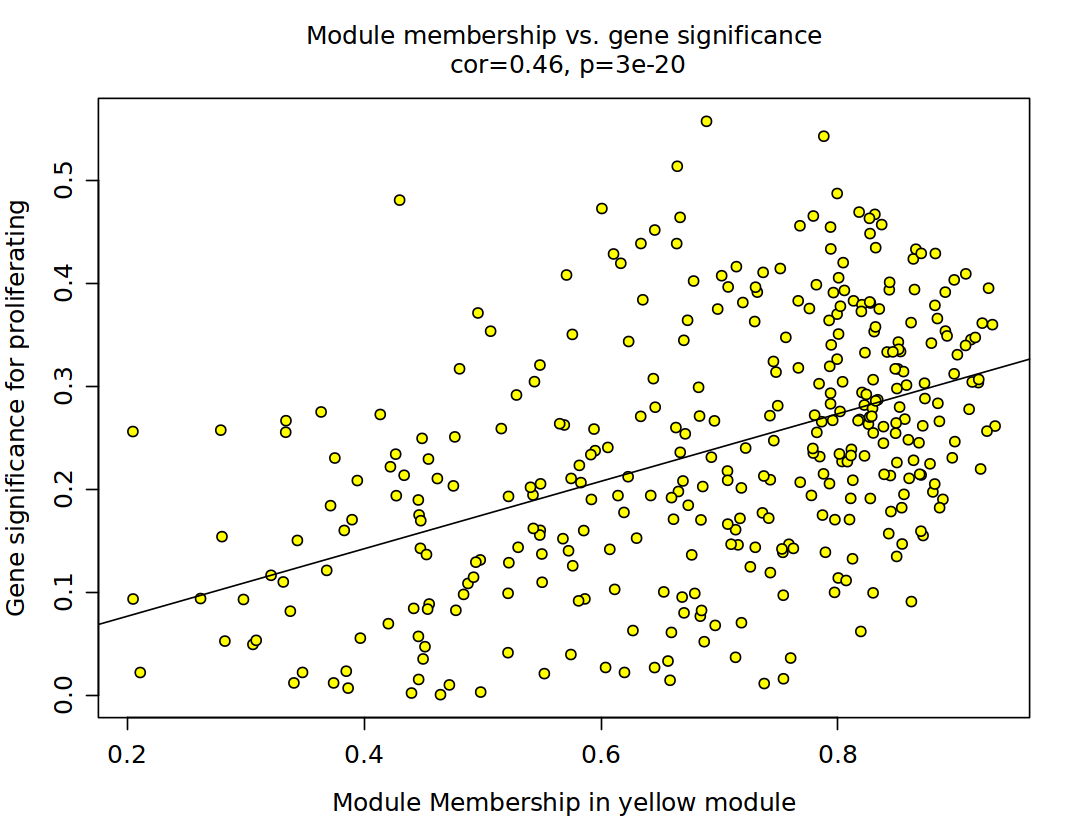

In [52]:
verboseScatterplot(
  MM, GS,
  xlab = paste("Module Membership in", module, "module"),
  ylab = "Gene significance for proliferating",
  main = paste("Module membership vs. gene significance\n"),
  abline = TRUE,
  pch = 21,
  cex.main = 1.2,
  cex.lab = 1.2,
  cex.axis = 1.2,
  col = "black",
  bg = module
)

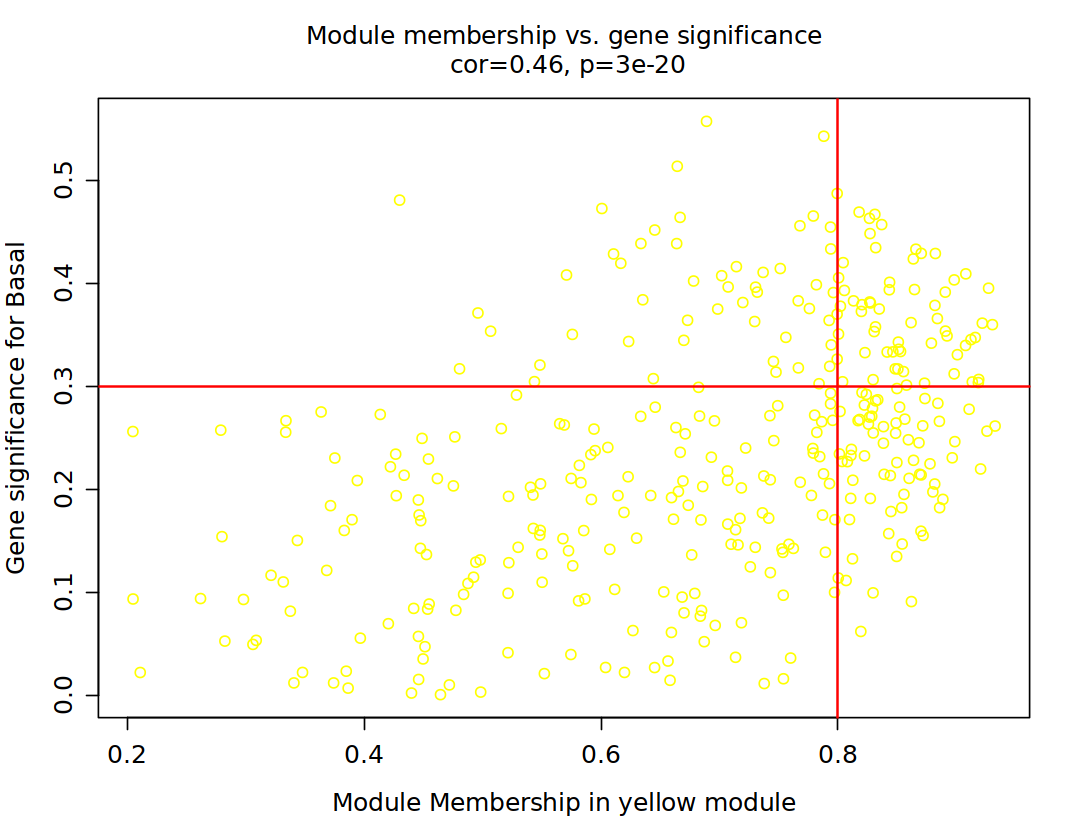

In [53]:
verboseScatterplot(MM, GS,
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Basal",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
abline(h=0.3,v=0.8,col="red",lwd=1.5)

In [54]:
brown_hub <- brown_moduleGenes[(GS > 0.3 & MM > 0.8)]
length(brown_hub)

[1] 59

In [55]:
write.csv(brown_hub,'brown_hub_gene.csv')

In [56]:
library(clusterProfiler)
library(org.Hs.eg.db)
options(stringsAsFactors = F)
 
brown_hub_gene <- read.csv('brown_hub_gene.csv',header = F)
brown_hub_gene <- brown_hub_gene[-1,]
brown_hub_gene <- brown_hub_gene[,-1]
gene=unique(brown_hub_gene)
##基因转ID
sig_DP_entrezId <- mapIds(x = org.Hs.eg.db,
                             keys = gene,
                             keytype = "SYMBOL",
                             column = "ENTREZID")


Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfil

In [57]:
table(is.na(sig_DP_entrezId))


FALSE  TRUE 
   58     1 

In [58]:

sig_DP_entrezId <- na.omit(sig_DP_entrezId)
go_bp <- enrichGO(gene = sig_DP_entrezId,
                      OrgDb = org.Hs.eg.db,
                      keyType = "ENTREZID",
                      ont = "ALL",
                      pvalueCutoff = 0.05,
                      qvalueCutoff = 1,
                      readable = TRUE)


In [59]:
go_bp@result

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0045730,BP,GO:0045730,respiratory burst,4/57,39/18903,5.647606e-06,4.777393e-03,4.124947e-03,HCK/NCF2/NCF4/SLC11A1,4
GO:0002430,BP,GO:0002430,complement receptor mediated signaling pathway,3/57,13/18903,7.277065e-06,4.777393e-03,4.124947e-03,C5AR2/FPR1/FPR2,3
GO:0006909,BP,GO:0006909,phagocytosis,7/57,314/18903,4.234759e-05,1.853413e-02,1.600293e-02,DYSF/FPR2/HCK/NCF2/NCF4/SLC11A1/TLR4,7
GO:0072593,BP,GO:0072593,reactive oxygen species metabolic process,6/57,235/18903,7.399017e-05,2.428727e-02,2.097037e-02,ALOX5/FPR2/NCF2/NCF4/PLIN5/TLR4,6
GO:0030667,CC,GO:0030667,secretory granule membrane,9/58,313/19869,2.880764e-07,4.436376e-05,3.972421e-05,CA4/CYSTM1/FCAR/FCGR2A/FPR1/FPR2/SIGLEC9/SLC11A1/SLC2A3,9
GO:0101003,CC,GO:0101003,ficolin-1-rich granule membrane,5/58,61/19869,9.331180e-07,5.598064e-05,5.012620e-05,FCAR/FPR1/FPR2/SLC11A1/SLC2A3,5
GO:0101002,CC,GO:0101002,ficolin-1-rich granule,7/58,185/19869,1.090532e-06,5.598064e-05,5.012620e-05,ALOX5/FCAR/FPR1/FPR2/HSPA6/SLC11A1/SLC2A3,7
GO:0070821,CC,GO:0070821,tertiary granule membrane,5/58,73/19869,2.293911e-06,8.831556e-05,7.907955e-05,CYSTM1/FCAR/FPR2/SLC11A1/SLC2A3,5
GO:0070820,CC,GO:0070820,tertiary granule,6/58,164/19869,8.189441e-06,2.522348e-04,2.258562e-04,CYSTM1/FCAR/FPR1/FPR2/SLC11A1/SLC2A3,6


In [64]:
options(repr.plot.width = 7)

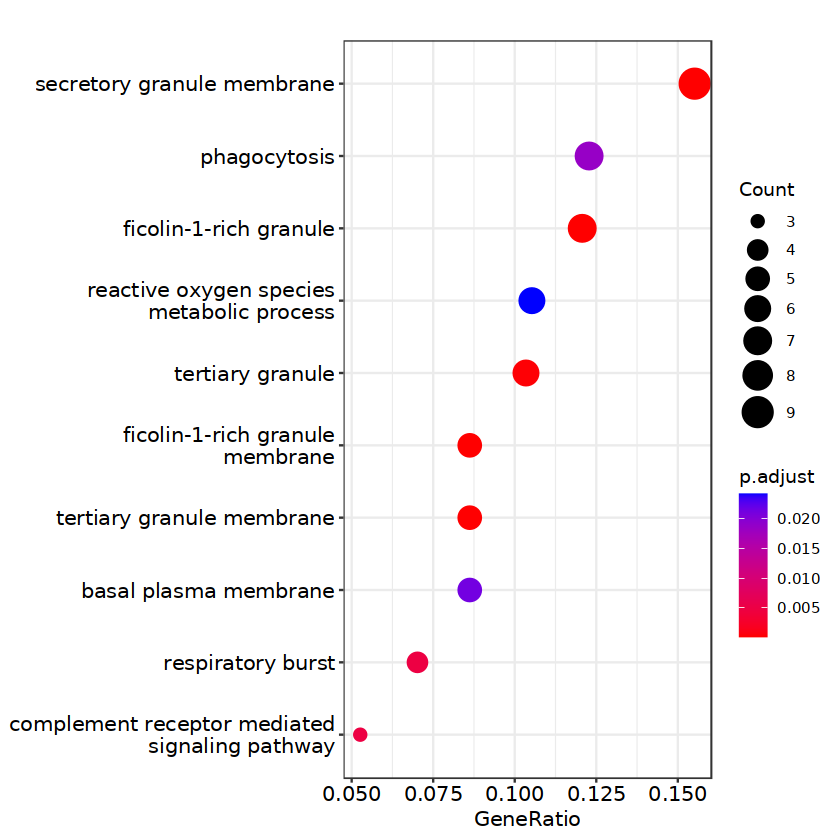

In [71]:
#画图
dotplot(go_bp)

ERROR: Error in pairwise_termsim(ek): could not find function "pairwise_termsim"


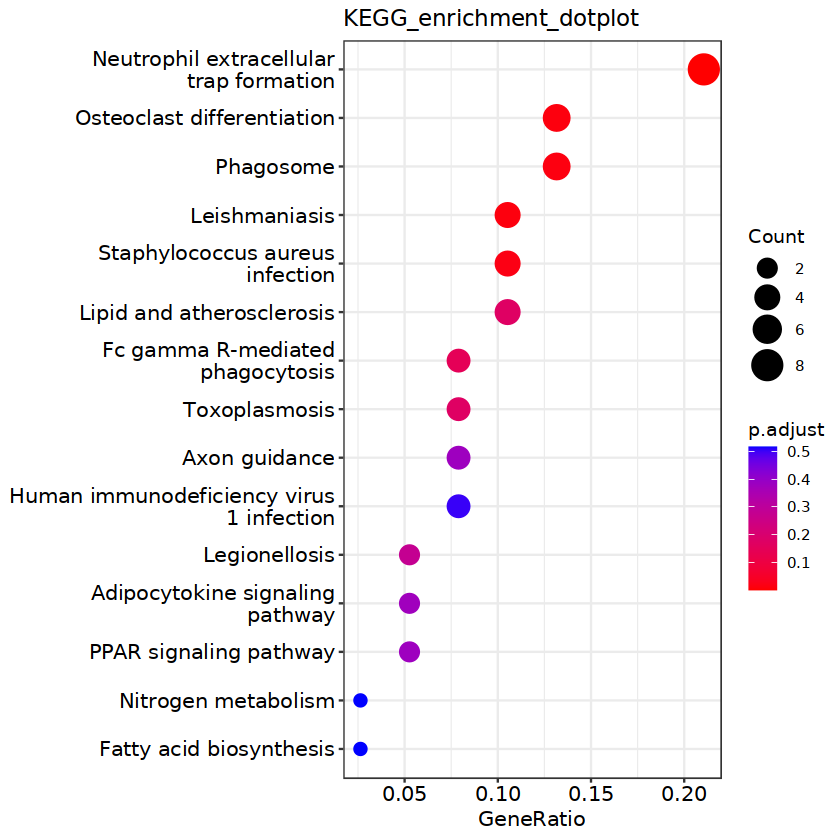

In [72]:
ek <- enrichKEGG(gene =sig_DP_entrezId , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result
    #write.csv(keggres,file = 'kegg_results.csv')
    enrichplot::dotplot(ek,  
            x = "GeneRatio", 
            color = "p.adjust", 
            showCategory = 15, 
            size = 'Count', 
            title = "KEGG_enrichment_dotplot"  
            )
    #ggsave('KEGG_enrichment_dotplot.pdf',height = 6,width = 6)
    KEGG2 <- pairwise_termsim(ek)
    
      

In [73]:
emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15)+
ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
    #ggsave('KEGG_enrichment_net.pdf',height = 8,width = 8)   

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'emapplot': object 'KEGG2' not found
